# Import library

In [1]:
import os
import sys
import datetime

from termcolor import colored, cprint

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
from os import listdir

import numpy as np
import pandas as pd  # Import Pandas and Numpy to create databases
import tensorflow as tf  # Import tensorflow to do tensor manipulations
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from chasm.glob import glob
scaler = StandardScaler()

In [2]:
phenotypes_labels = {
    "bc": "Breast Cancer",
    "cad": "Coronary Artery Disease",
    "ms": "Multiple Sclerosis",
    "t2d": "Type 2 Diabetes",
    "pc": "Prostate Cancer",
    "ibd": "Inflammatory Bowel Disease"
}

scenario_labels = {
    "no_cov": "no covariates",
    "abyss": "Abyss correction",
    "cov": "PCA correction",
    "abyss_cov": "Abyss + PCA as covariates"
}

# Load sumstats

In [3]:
disease = "ms"
scenario = "abyss"

In [4]:
path_input = glob.PATH_GENO + f"/01_summary_statistics/{disease}/{scenario}"
list_of_bins = os.listdir(path_input)
list_of_dfs = []
for bin in list_of_bins:
    try:
        temp = pd.read_pickle(path_input+f"/{bin}")
        temp['bin'] = bin.split('_')[1]
        
        # Sort by -logp in descending order and take the top 1000 SNPs
        top_snps = temp.sort_values(by='-logp', ascending=False)
        
        list_of_dfs.append(top_snps)
    except Exception as e:
        print(e)
        print(f"Problem with chrom {bin}")

# Concatenating the top SNPs from each bin
sumstat = pd.concat(list_of_dfs)

# Sorting by chromosome if needed
sumstat = sumstat.sort_values(by='#CHROM', ascending=True)

In [5]:
sumstat = sumstat[sumstat['-logp']>7]
sumstat = sumstat[sumstat['-logp']<100]

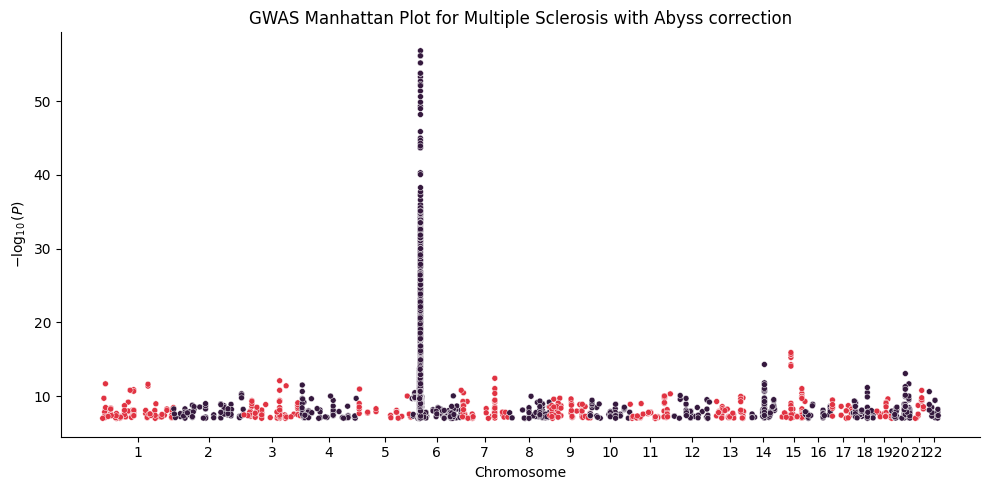

In [6]:
running_pos = 0
cumulative_pos = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    cumulative_pos.append(group_df['POS'] + running_pos)
    running_pos += group_df['POS'].max()

sumstat['cumulative_pos'] = pd.concat(cumulative_pos)
sumstat['SNP number'] = sumstat.index

# Define two contrasting colors from the rocket palette
palette = sns.color_palette("rocket", as_cmap=False)
color1 = palette[3]  # First color of the palette
color2 = palette[0] # Last color of the palette, for maximum contrast

# Function to assign color based on chromosome
def assign_color(chrom_number):
    return color1 if chrom_number % 2 == 0 else color2

# Apply the function to create a color column
sumstat['color'] = sumstat['#CHROM'].apply(assign_color)

chrom_midpoints = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    midpoint = group_df['cumulative_pos'].min() + (group_df['cumulative_pos'].max() - group_df['cumulative_pos'].min()) / 2
    chrom_midpoints.append(midpoint)

# Plotting
g = sns.relplot(
    data=sumstat,
    x='cumulative_pos',
    y='-logp',
    aspect=2,
    hue='color',
    palette=[color1, color2],
    legend=False,
    size=3 
)


# Set x-axis ticks and labels with reversed chromosome order
chrom_labels = np.sort(sumstat['#CHROM'].unique()) # Reversing the order of chromosomes

# Set the title and x-axis, y-axis labels
g.set(title=f"GWAS Manhattan Plot for {phenotypes_labels[disease]} with {scenario_labels[scenario]}")
g.set(xticks=chrom_midpoints, xticklabels=chrom_labels)
g.set_axis_labels("Chromosome", r"$-\log_{10}(P)$")  # Set y-axis label with subscript

# Set the tick labels at a 45-degree angle
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Optional: Improve the layout
plt.tight_layout()
plt.show()

# Find the mapping files

In [7]:
maps = []
list_of_bins = os.listdir(f"{glob.PATH_usefull}/mapping_LD_blocks_to_files")
for bin in list_of_bins:
    path_map = f"{glob.PATH_usefull}/mapping_LD_blocks_to_files/{bin}/mapping.pkl"
    map = pd.read_pickle(path_map)
    maps.append(map)

In [8]:
map = pd.concat(maps, ignore_index=True)

In [9]:
map['snp'] = map['Chromosome'].astype(str) + ':' + map['Position'].astype(str) + ':' + map['Alls2']

In [10]:
# Merge the DataFrames on the 'snp' column
merged_df = map.merge(sumstat, on='snp')

In [11]:
sorted_df = merged_df.sort_values(by=['bin', 'path'])

In [12]:
grouped = sorted_df.groupby('bin').apply(lambda x: x.drop_duplicates(subset='path'))

In [22]:
output_directory = f"../../data/mapping_files/"

In [23]:
os.makedirs(output_directory,exist_ok=True)

In [24]:
# Create and write to files in the specified directory
for bin_value, group in grouped.groupby(level=0):
    filename = os.path.join(output_directory, f'needed_files_bin_{bin_value}.txt')
    with open(filename, 'w') as file:
        for path in group['path']:
            file.write(path + '\n')

print("Files created successfully.")

Files created successfully.


In [25]:

# Assuming the files are in the current directory
directory = f"../../data/mapping_files/"  # Replace with your directory if different

for bin_num in range(1, 33):  # For each bin from 1 to 32
    # Read needed files
    needed_filename = os.path.join(directory, f'needed_files_bin_{bin_num}.txt')
    with open(needed_filename, 'r') as file:
        needed_files = [line.strip() for line in file]

    # Read file list
    file_list_filename = os.path.join(directory, f'file_list_bin_{bin_num}.txt')
    with open(file_list_filename, 'r') as file:
        file_list = [line.strip() for line in file]

    # Filter file list based on needed files
    filtered_files = [file for file in file_list if any(file.startswith(needed) for needed in needed_files)]

    # Write filtered list to new file
    output_filename = os.path.join(directory, f'file_list_needed_bin_{bin_num}.txt')
    with open(output_filename, 'w') as file:
        for item in filtered_files:
            file.write(item + '\n')

print("Filtered files created successfully.")

Filtered files created successfully.
